In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: mps


In [3]:
mnist_train = dsets.FashionMNIST(root='F_MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.FashionMNIST(root='F_MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 64
training_epochs = 32
data_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size, # 배치 크기는 100
                        shuffle=True,
                        drop_last=True)

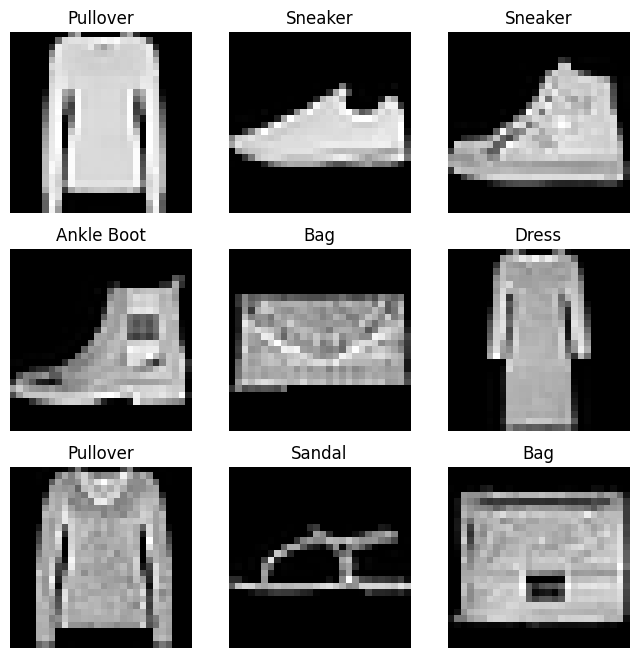

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
batch_size = 64
training_epochs = 20
train_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

test_loader = DataLoader(dataset=mnist_test,
                        batch_size=batch_size, 
                        shuffle=True)

In [12]:
cost_dict = {'train':[], 'test':[]}
test_acc_arr = []
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

def train(model, data_loader, optimizer):
    model.train()  # 신경망을 학습 모드로 전환
    train_cost = 0
    total_batch = len(data_loader)

    for i, (X, Y) in enumerate(data_loader):
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)
        optimizer.zero_grad()
        prediction = model(X)
        cost = criterion(prediction, Y)
        cost.backward()
        optimizer.step()

        train_cost += cost / total_batch
    cost_dict['train'].append(train_cost)
    print('Epoch:', '{}'.format(i + 1), 'cost =', '{:.9f}'.format(train_cost))

def validation(test_loader, model):
    model.eval()
    test_cost = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            test_cost += F.cross_entropy(y_pred, y_test, reduction='sum').item()
            _, predicted = torch.max(y_pred.data, 1)
            correct += predicted.eq(y_test.data.view_as(predicted)).sum()
    
    test_cost /= len(test_loader.dataset)
    cost_dict['test'].append(test_cost)

    test_acc = correct / len(test_loader.dataset)
    test_acc_arr.append(test_acc)
    print('test acc ::: ', test_acc , ' test loss :::', test_cost)

In [7]:
torch.manual_seed(777)

In [17]:
inputs = torch.Tensor(1, 1, 28, 28)
layer1 =torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

print(layer1(inputs).shape)
print(layer2(layer1(inputs)).shape)
print(layer3(layer2(layer1(inputs))).shape)
print(layer4(layer3(layer2(layer1(inputs)))).shape)

torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 128, 3, 3])
torch.Size([1, 256, 2, 2])


In [18]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(2 * 2 * 256, 1024, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = torch.nn.Linear(1024, 256, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            self.fc2,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc3 = torch.nn.Linear(256, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer5(out)
        out = self.fc3(out)
        return out
        
model = CNN()
model.to(device)

In [19]:
cost_dict = {'train':[], 'test':[]}
test_acc_arr = []
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

def train(model, data_loader, optimizer):
    model.train()  # 신경망을 학습 모드로 전환
    train_cost = 0
    total_batch = len(data_loader)

    for i, (X, Y) in enumerate(data_loader):
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)
        optimizer.zero_grad()
        prediction = model(X)
        cost = criterion(prediction, Y)
        cost.backward()
        optimizer.step()

        train_cost += cost / total_batch
    cost_dict['train'].append(train_cost)
    print('Epoch:', '{}'.format(i + 1), 'cost =', '{:.9f}'.format(train_cost))

def validation(test_loader, model):
    model.eval()
    test_cost = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            test_cost += F.cross_entropy(y_pred, y_test, reduction='sum').item()
            _, predicted = torch.max(y_pred.data, 1)
            correct += predicted.eq(y_test.data.view_as(predicted)).sum()
    
    test_cost /= len(test_loader.dataset)
    cost_dict['test'].append(test_cost)

    test_acc = correct / len(test_loader.dataset)
    test_acc_arr.append(test_acc)
    print('test acc ::: ', test_acc , ' test loss :::', test_cost)

In [21]:
for epoch in range(1, training_epochs+1):
    train(model, train_loader, optimizer)
    validation(test_loader, model)

Epoch: 937 cost = 0.552471697
test acc :::  tensor(0.8660, device='mps:0')  test loss ::: 0.36711193075180054


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Epoch: 937 cost = 0.366841048
test acc :::  tensor(0.8641, device='mps:0')  test loss ::: 0.38405820112228395
Epoch: 937 cost = 0.340194196
test acc :::  tensor(0.8763, device='mps:0')  test loss ::: 0.3541851535320282
Epoch: 937 cost = 0.316863269
test acc :::  tensor(0.8830, device='mps:0')  test loss ::: 0.32738724470138547
Epoch: 937 cost = 0.305572629
test acc :::  tensor(0.8849, device='mps:0')  test loss ::: 0.3377053068876266
Epoch: 937 cost = 0.294009626
test acc :::  tensor(0.8874, device='mps:0')  test loss ::: 0.33886489877700804
Epoch: 937 cost = 0.286465406
test acc :::  tensor(0.8898, device='mps:0')  test loss ::: 0.3139550392150879
Epoch: 937 cost = 0.282544672
test acc :::  tensor(0.8895, device='mps:0')  test loss ::: 0.33242360653877256
Epoch: 937 cost = 0.282038420
test acc :::  tensor(0.8925, device='mps:0')  test loss ::: 0.32740435819625857
Epoch: 937 cost = 0.269452274
test acc :::  tensor(0.8925, device='mps:0')  test loss ::: 0.33209907665252686
Epoch: 937 co

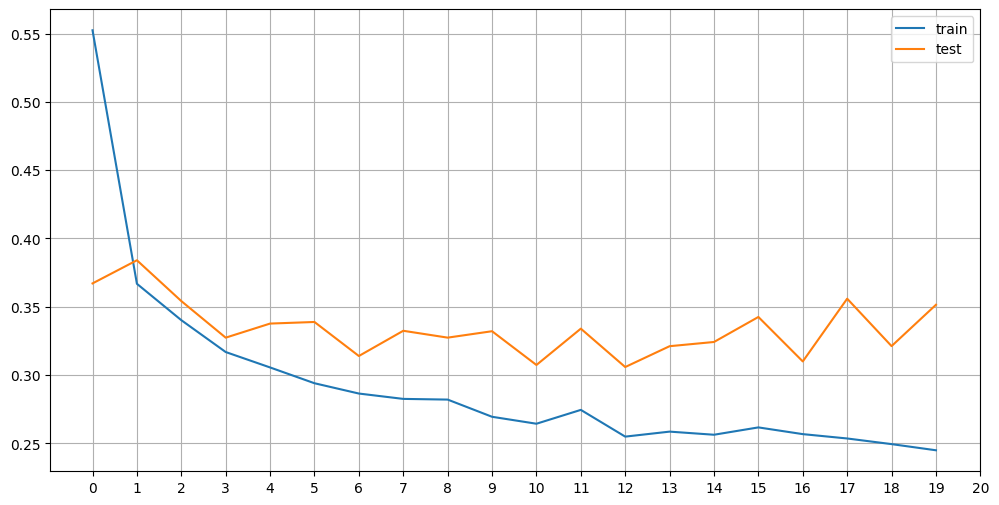

In [22]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in cost_dict['train']], label='train')
plt.plot(cost_dict['test'], label='test')
plt.grid()
plt.xticks(range(training_epochs+1))
plt.legend()
plt.show()

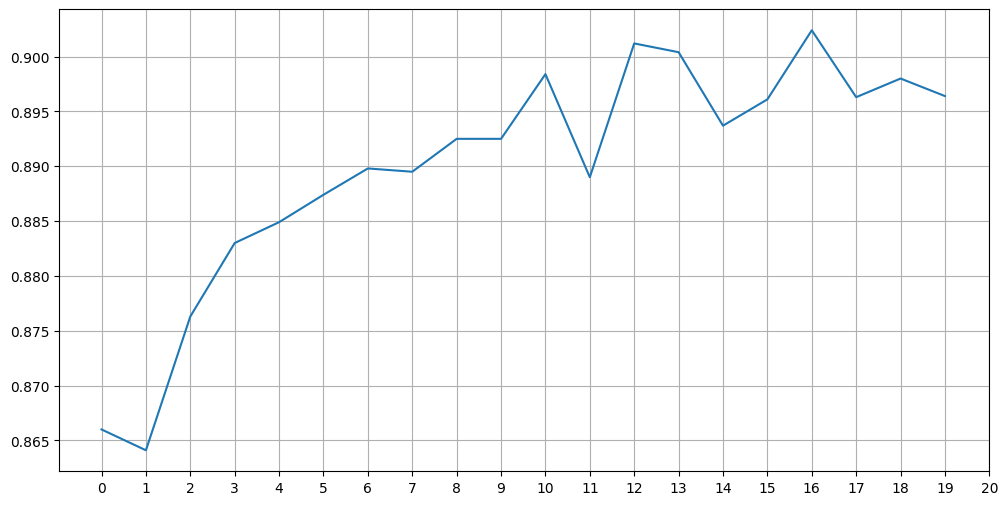

In [23]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in test_acc_arr])
plt.xticks(range(training_epochs+1))
plt.grid()
plt.show()

In [7]:
inputs = torch.Tensor(1, 1, 28, 28)
layer1 =torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))


print(layer1(inputs).shape)
print(layer2(layer1(inputs)).shape)
print(layer3(layer2(layer1(inputs))).shape)


torch.Size([1, 64, 14, 14])
torch.Size([1, 128, 7, 7])
torch.Size([1, 256, 4, 4])


In [13]:
class CNN_2(torch.nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.keep_prob = 0.5
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2,padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 256, 1024, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(1024, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out
        
model = CNN_2()
model.to(device)

criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

In [14]:
torch.manual_seed(777)

In [15]:
cost_dict = {'train':[], 'test':[]}
test_acc_arr = []
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

def train(model, data_loader, optimizer):
    model.train()  # 신경망을 학습 모드로 전환
    train_cost = 0
    total_batch = len(data_loader)

    for i, (X, Y) in enumerate(data_loader):
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)
        optimizer.zero_grad()
        prediction = model(X)
        cost = criterion(prediction, Y)
        cost.backward()
        optimizer.step()

        train_cost += cost / total_batch
    cost_dict['train'].append(train_cost)
    print('Epoch:', '{}'.format(i + 1), 'cost =', '{:.9f}'.format(train_cost))

def validation(test_loader, model):
    model.eval()
    test_cost = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            test_cost += F.cross_entropy(y_pred, y_test, reduction='sum').item()
            _, predicted = torch.max(y_pred.data, 1)
            correct += predicted.eq(y_test.data.view_as(predicted)).sum()
    
    test_cost /= len(test_loader.dataset)
    cost_dict['test'].append(test_cost)

    test_acc = correct / len(test_loader.dataset)
    test_acc_arr.append(test_acc)
    print('test acc ::: ', test_acc , ' test loss :::', test_cost)

In [16]:
for epoch in range(1, training_epochs+1):
    train(model, train_loader, optimizer)
    validation(test_loader, model)

Epoch: 937 cost = 0.480367631
test acc :::  tensor(0.8582, device='mps:0')  test loss ::: 0.38647041263580323


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Epoch: 937 cost = 0.309165388
test acc :::  tensor(0.8835, device='mps:0')  test loss ::: 0.31554791555404665
Epoch: 937 cost = 0.272742808
test acc :::  tensor(0.9011, device='mps:0')  test loss ::: 0.2703959135532379
Epoch: 937 cost = 0.247919157
test acc :::  tensor(0.9007, device='mps:0')  test loss ::: 0.2792720536708832
Epoch: 937 cost = 0.228685752
test acc :::  tensor(0.9073, device='mps:0')  test loss ::: 0.26821996152400973
Epoch: 937 cost = 0.216191217
test acc :::  tensor(0.9091, device='mps:0')  test loss ::: 0.25411747374534605
Epoch: 937 cost = 0.203950584
test acc :::  tensor(0.9036, device='mps:0')  test loss ::: 0.2812279920578003
Epoch: 937 cost = 0.195292726
test acc :::  tensor(0.9119, device='mps:0')  test loss ::: 0.26293529901504514
Epoch: 937 cost = 0.181027547
test acc :::  tensor(0.9096, device='mps:0')  test loss ::: 0.2760128799498081
Epoch: 937 cost = 0.168881074
test acc :::  tensor(0.9098, device='mps:0')  test loss ::: 0.27091967298984526
Epoch: 937 cos

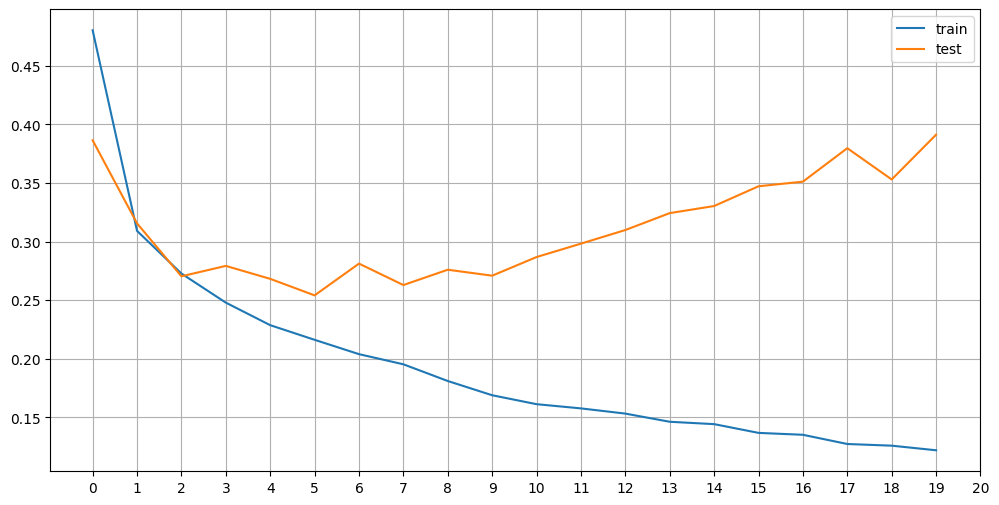

In [17]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in cost_dict['train']], label='train')
plt.plot(cost_dict['test'], label='test')
plt.grid()
plt.xticks(range(training_epochs+1))
plt.legend()
plt.show()

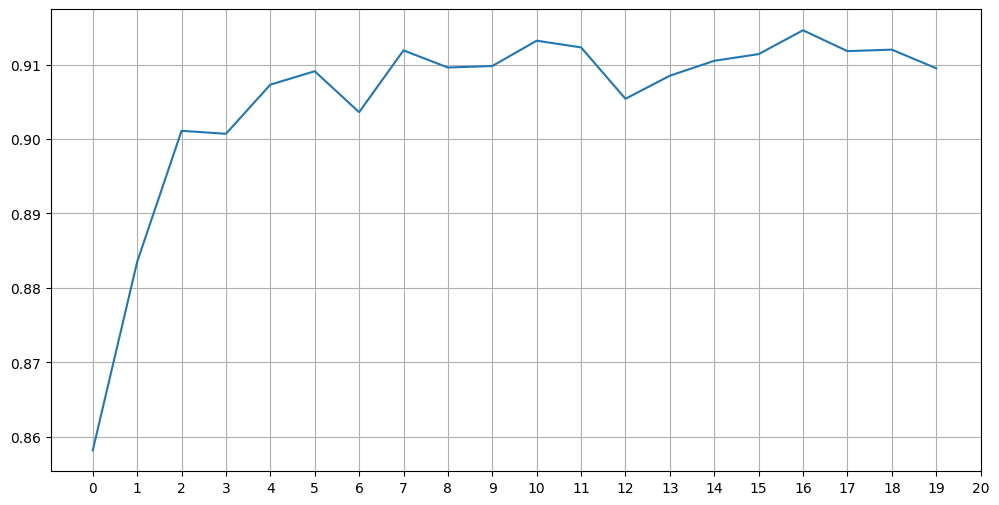

In [18]:
plt.figure(figsize=(12,6))
plt.plot([t.item() for t in test_acc_arr])
plt.xticks(range(training_epochs+1))
plt.grid()
plt.show()